In [130]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as rng
from scipy.special import expit as sigmoid

def load_mnist_digit(digit, dataset_size):
    assert(digit >= 0 and digit < 10)
    with open("datasets/{}.npy".format(digit),'rb') as f:
        return np.load(f)[:dataset_size]
    
def flatten_dataset(images):
    smushed = images.copy()
    return smushed.reshape((smushed.shape[0], -1))

dataset_size = 500  # that's how many of EACH digit there is. Can go as high as... what, 500?

vis_train_pats = flatten_dataset(load_mnist_digit(2,dataset_size))
for i in []:
    vis_train_pats = np.vstack((vis_train_pats, flatten_dataset(load_mnist_digit(i,dataset_size))))

In [131]:
print (vis_train_pats.shape)
num_pats = vis_train_pats.shape[0]
rand_order = rng.permutation(np.arange(num_pats))
vis_train_pats = vis_train_pats[rand_order]
num_visibles = vis_train_pats.shape[1]
# THIS WRITES LIST OF DIGIT IMAGES AS A CSV TO A PLAIN TXT FILE
# np.savetxt(fname='mnist_500_each_digit.txt', X=vis_train_pats, fmt='%.2f', delimiter=',')

(500, 784)


## Show some examples....

(500, 784)


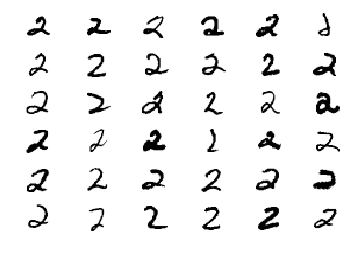

In [197]:
print(vis_train_pats.shape)
i=0
for r in range(6):
    for c in range(6):
        plt.subplot(6,6,i+1)
        plt.imshow(vis_train_pats[i].reshape(28,28), cmap='Greys', interpolation='nearest')
        plt.axis('off')
        i += 1

## Do some learning, using CD1 (contrastive divergence)

In [229]:
import time

def train(indata, num_hiddens, wgts, changes, num_iterations, rate, momentum, L1_penalty, minibatch_size, DROPOUT):
    W, hid_bias, vis_bias = wgts
    W_change, hid_bias_change, vis_bias_change = changes
    announce_every = num_iterations / 10

    start = time.time()
    rand_order = rng.permutation(np.arange(num_pats))

    for t in range(num_iterations+1):
        if DROPOUT:  dropout = rng.randint(2, size=(minibatch_size, num_hiddens))

            
        start_index = 0
        while start_index < num_pats-1:
            #print('start index: %d' % start_index)
            next_index = min(start_index + minibatch_size, num_pats)
            vis_minibatch = indata[start_index:next_index]
            start_index = next_index  # ready for next time

            # push visible pats into hidden 
            hid_prob1 = sigmoid(np.dot(vis_minibatch, W.T) + hid_bias)
            hid_first = 1*(hid_prob1 > rng.random(size=hid_prob1.shape))
            if DROPOUT: hid_first = hid_first * dropout

            # push hidden pats into visible 
            vis_prob1 = sigmoid(np.dot(hid_first, W) + vis_bias)
            vis_reconstruction = vis_prob1  # = 1*(v_prob1 > rng.random(size=v_prob1.shape))

            # push visible pats into hidden 
            hid_prob1 = sigmoid(np.dot(vis_reconstruction, W.T) + hid_bias)
            hid_second = 1*(hid_prob1 > rng.random(size=hid_prob1.shape))

            # THIS WAY IS REALLY MEMORY-INTENSIVE AND SLOW - USE EINSTEIN INSTEAD!
            # Hebb = ((np.array([h_first]*num_visibles).T)  * (np.array([v]*num_hiddens))).sum(1)
            # AntiHebb = ((np.array([h_second]*num_visibles).T)  * (np.array([v_reconstruction]*num_hiddens))).sum(1)

            # Einstein alternative suggested by Paul Mathews.
            Hebb = np.einsum('ij,ik->jk', hid_first, vis_minibatch) 
            AntiHebb = np.einsum('ij,ik->jk', hid_second, vis_reconstruction) 

            W_change = rate * (Hebb - AntiHebb)/minibatch_size  +  momentum * W_change
            W += W_change - L1_penalty * np.sign(W)

            # Now we have to do the visible and hidden bias weights as well.
            hid_bias_change = rate * (hid_first.mean(0) - hid_second.mean(0))   +  momentum * hid_bias_change
            hid_bias += hid_bias_change
            vis_bias_change = rate * (vis_minibatch.mean(0) - vis_reconstruction.mean(0))   +  momentum * vis_bias_change
            vis_bias += vis_bias_change
            
        if (t % announce_every == 0): 
            C = np.power(2, vis_reconstruction - vis_minibatch).mean()
            print ('Iteration %5d \t TIME (secs): %.1f,  RMSreconstruction: %.4f' % (t, time.time() - start, C))

    
    return (W, hid_bias, vis_bias), (W_change, hid_bias_change, vis_bias_change)

### Start from random initial weights and bias weights

In [230]:
num_hiddens = 100
W = 0.1*rng.normal(0,1,size=(num_hiddens, num_visibles))
hid_bias = 0.01*rng.normal(size=(1, num_hiddens))
vis_bias = 0.01*rng.normal(size=(1, num_visibles))
print(vis_train_pats.shape)

(500, 784)


In [237]:
iterations = 100
learning_rate, momentum = 0.05, 0.95
L1_penalty = 0.0001
minibatch_size = 100
DROPOUT = True
wgts = (W, hid_bias, vis_bias)
changes = (0.0, 0.0, 0.0)

### do some training

In [238]:
wgts, changes = train(vis_train_pats, num_hiddens,  wgts, changes, iterations, 0.01, 0.5, L1_penalty, minibatch_size, DROPOUT)
wgts, changes = train(vis_train_pats, num_hiddens,  wgts, changes, iterations, learning_rate, momentum, L1_penalty, minibatch_size, DROPOUT)

Iteration     0 	 TIME (secs): 0.3,  RMSreconstruction: 1.0131
Iteration    10 	 TIME (secs): 3.0,  RMSreconstruction: 1.0125
Iteration    20 	 TIME (secs): 5.8,  RMSreconstruction: 1.0117
Iteration    30 	 TIME (secs): 8.5,  RMSreconstruction: 1.0128
Iteration    40 	 TIME (secs): 11.3,  RMSreconstruction: 1.0122
Iteration    50 	 TIME (secs): 14.2,  RMSreconstruction: 1.0122
Iteration    60 	 TIME (secs): 17.0,  RMSreconstruction: 1.0107
Iteration    70 	 TIME (secs): 19.8,  RMSreconstruction: 1.0122
Iteration    80 	 TIME (secs): 22.5,  RMSreconstruction: 1.0123
Iteration    90 	 TIME (secs): 25.4,  RMSreconstruction: 1.0116
Iteration   100 	 TIME (secs): 28.2,  RMSreconstruction: 1.0135
Iteration     0 	 TIME (secs): 0.3,  RMSreconstruction: 1.0112
Iteration    10 	 TIME (secs): 3.0,  RMSreconstruction: 1.0111
Iteration    20 	 TIME (secs): 5.8,  RMSreconstruction: 1.0114
Iteration    30 	 TIME (secs): 8.6,  RMSreconstruction: 1.0107
Iteration    40 	 TIME (secs): 11.4,  RMSreconst

### reality-check some of the latest Hebb updates 
by looking at the weight updates being prescribed for some particular hidden units.

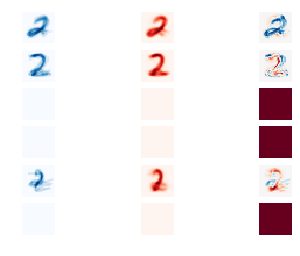

In [239]:
nr, nc = 6, 3
plot_counter = 1
for r in range(nr):
    i = rng.randint(minibatch_size)
    plt.subplot(nr,nc,plot_counter)
    plt.imshow(Hebb[i].reshape(28,28), interpolation='nearest',cmap='Blues')
    plt.axis('off')
    plot_counter += 1
    
    plt.subplot(nr,nc,plot_counter)
    plt.imshow(AntiHebb[i].reshape(28,28), interpolation='nearest',cmap='Reds')
    plt.axis('off')
    plot_counter += 1
    
    plt.subplot(nr,nc,plot_counter)
    mx = np.max(np.abs((Hebb[i] - AntiHebb[i])))
    plt.imshow((Hebb[i] - AntiHebb[i]).reshape(28,28), interpolation='nearest',cmap='RdBu', vmin=-mx, vmax=mx)
    plt.axis('off')
    plot_counter += 1

## features (ie. the current weights...)
I could draw the visible bias weights as an image here too....

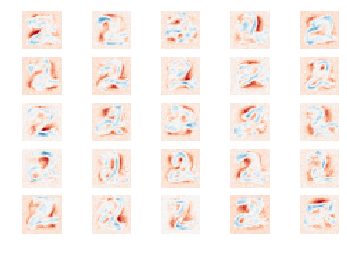

In [240]:
i=0
mx = np.max(np.abs(W))
for r in range(5):
    for c in range(5):
        plt.subplot(5,5,i+1)
        plt.imshow(W[i].reshape(28,28), interpolation='nearest',cmap='RdBu', vmin=-mx, vmax=mx)
        plt.axis('off')
        i += 1

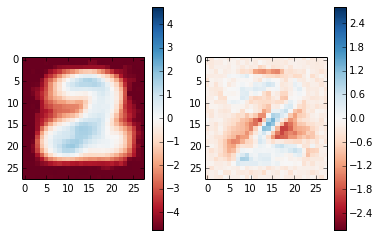

In [256]:
# show the bias weights, and show a random hidden unit's weights, large...
plt.subplot(121)
mx = np.max(np.abs(vis_bias))
plt.imshow(vis_bias.reshape(28,28), interpolation='nearest', cmap='RdBu', vmin=-mx, vmax=mx)
plt.colorbar()
plt.subplot(122)
i = rng.randint(num_hiddens)
mx = np.max(np.abs(W))
plt.imshow(W[i].reshape(28,28), interpolation='nearest', cmap='RdBu', vmin=-mx, vmax=mx)
plt.colorbar()

## dreams
I think I'll try some "dreams" that start on actual training patterns.
I'll show them (but less and less often) as the Gibbs chain random-walks away from this initial point, and see how they diverge, and what they diverge TO.

So, presumably we should see them falling away from their initial state into the land of dreams as the model loses track of where it started from.

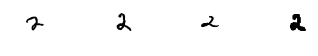

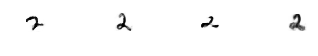

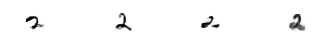

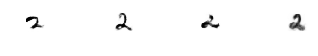

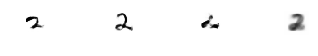

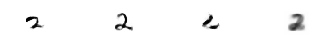

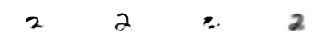

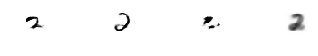

In [244]:
num_examples = 4
Vis_test = np.copy(vis_train_pats[rng.randint(0, num_pats, size=(num_examples)), :])
i = 0
num_Gibbs = 0
num_rows = 8
for s in range(num_rows):
    for t in range(num_Gibbs):
        # push visible pats into hidden 
        hid_prob1 = sigmoid(np.dot(Vis_test, W.T) + hid_bias)
        hid = 1*(hid_prob1 > rng.random(size=hid_prob1.shape))
        # push hidden pats into visible 
        vis_prob1 = sigmoid(np.dot(hid, W) + vis_bias)
        Vis_test = vis_prob1  # OR....  1*(v_prob1 > rng.random(size=v_prob1.shape))
    for n in range(num_examples):
        i += 1
        plt.subplot(num_rows,num_examples,i)
        plt.imshow(Vis_test[n].reshape(28,28), cmap='Greys', vmin=0., vmax=1., interpolation='nearest')
        plt.axis('off')
        
    num_Gibbs = max(1, num_Gibbs * 4)  # wait X times longer each time before showing the next sample.
    plt.show()

And now starting from some truly random initial patterns..............

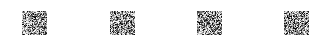

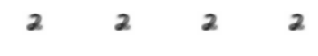

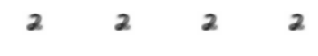

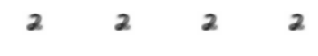

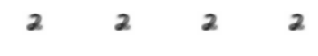

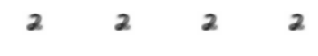

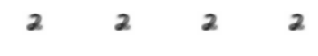

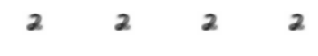

In [243]:
num_examples = 4
Vis_test = rng.random(size=(num_examples, num_visibles))
i = 0
num_Gibbs = 0
num_rows = 8
for s in range(num_rows):
    for t in range(num_Gibbs):
        # push visible pats into hidden 
        hid_prob1 = sigmoid(np.dot(Vis_test, W.T) + hid_bias)
        hid = 1*(hid_prob1 > rng.random(size=hid_prob1.shape))
        # push hidden pats into visible 
        vis_prob1 = sigmoid(np.dot(hid, W) + vis_bias)
        Vis_test = vis_prob1  # OR....  1*(v_prob1 > rng.random(size=v_prob1.shape))
    for n in range(num_examples):
        i += 1
        plt.subplot(num_rows, num_examples, i)
        plt.imshow(Vis_test[n].reshape(28,28), cmap='Greys', vmin=0., vmax=1., interpolation='nearest')
        plt.axis('off')
        
    num_Gibbs = max(1, num_Gibbs * 4)  # wait longer before showing the next sample...
    plt.show()

In [141]:
np.savez('./RBM_weights.npz', W=W, hid_bias=hid_bias, vis_bias=vis_bias)